# Diamond Pricing Analysis
## Authored by Trinity Gahagen
#### Phase 3 Project for Flatiron School
---
---

# Table of Contents
1. [Data Overview](#data-overview)
    1. [Inital Data Exploration](#initial-data-exploration)
2. [EDA: Descriptive Analysis](#eda-descriptive-analysis)

# Data Overview
---

*Dataset Kaggle Page:* https://www.kaggle.com/datasets/miguelcorraljr/brilliant-diamonds

This dataset was scraped back in 2020 off of Brilliant Earth's diamond catalogue. It hosts the folllowing columns:

|Attribute|	Description	|Data Type|
|---------|-------------|---------|
|id|Diamond identification number provided by Brilliant Earth|int
|url|URL for the diamond details page|string
|shape|External geometric appearance of a diamond|string/categorical
|price|Price in U.S. dollars|int
|carat|Unit of measurement used to describe the weight of a diamond|float
|cut|Facets, symmetry, and reflective qualities of a diamond|string/categorical
|color|Natural color or lack of color visible within a diamond, based on the GIA grade scale|string/categorical
|clarity|Visibility of natural microscopic inclusions and imperfections within a diamond|string/categorical
|report|Diamond certificate or grading report provided by an independent gemology lab|string
|type|Natural or lab created diamonds|string
|date_fetched|Date the data was fetched|date

### Initial Data Exploration/Cleaning

In [31]:
# Base Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot styles
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 11
from matplotlib.ticker import FuncFormatter

# Statistical modules
import scipy.stats as stats

# ML Tools
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
# Classification metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, roc_auc_score
# Regression metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score

# ML Models
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [32]:
diamonds = pd.read_csv('diamonds_dataset.csv')

In [33]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119307 entries, 0 to 119306
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            119307 non-null  int64  
 1   url           119307 non-null  object 
 2   shape         119307 non-null  object 
 3   price         119307 non-null  int64  
 4   carat         119307 non-null  float64
 5   cut           119307 non-null  object 
 6   color         119307 non-null  object 
 7   clarity       119307 non-null  object 
 8   report        119307 non-null  object 
 9   type          119307 non-null  object 
 10  date_fetched  119307 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 10.0+ MB


In [34]:
diamonds.describe()

,id,price,carat
count,1.193070e+05,1.193070e+05,119307.000000
mean,9.905507e+06,3.286843e+03,0.884169
std,2.373824e+05,9.114695e+03,0.671141
min,4.367730e+05,2.700000e+02,0.250000
25%,9.854352e+06,9.000000e+02,0.400000
50%,9.978096e+06,1.770000e+03,0.700000
75%,1.005433e+07,3.490000e+03,1.100000
max,1.009225e+07,1.348720e+06,15.320000


In [35]:
diamonds.describe(include='O')

,url,shape,cut,color,clarity,report,type,date_fetched
count,119307,119307,119307,119307,119307,119307,119307,119307
unique,119307,10,5,7,8,4,2,1
top,https://www.brilliantearth.com//loose-diamonds...,Round,Super Ideal,E,VS1,GIA,natural,2020-11-29 12-26 PM
freq,1,76080,55244,24730,27259,68782,70313,119307


In [36]:
categorical_cols = ['shape', 'cut', 'color', 'clarity', 'report', 'type']
for col in categorical_cols:
    print(f"Unique values in {col}: {diamonds[col].unique()}")

Unique values in shape: ['Round' 'Emerald' 'Marquise' 'Princess' 'Pear' 'Heart' 'Oval' 'Cushion'
 'Asscher' 'Radiant']
Unique values in cut: ['Very Good' 'Ideal' 'Super Ideal' 'Good' 'Fair']
Unique values in color: ['J' 'I' 'E' 'F' 'G' 'H' 'D']
Unique values in clarity: ['SI2' 'SI1' 'VS2' 'VVS1' 'VS1' 'VVS2' 'IF' 'FL']
Unique values in report: ['GIA' 'HRD' 'IGI' 'GCAL']
Unique values in type: ['natural' 'lab']


In [37]:
# ID, url, and date_fetched are all useless columns
try:
    diamonds.drop(columns=['id', 'url', 'date_fetched'], inplace=True)
except:
    print('Columns already dropped')

In [38]:
# Create categorical columns with inherent order
diamonds['cut'] = pd.Categorical(diamonds['cut'], categories=['Fair', 'Good', 'Very Good', 'Ideal', 'Super Ideal'], ordered=True)
diamonds['clarity'] = pd.Categorical(diamonds['clarity'], categories=['SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF', 'FL'], ordered=True)
diamonds['color'] = pd.Categorical(diamonds['color'], categories=['J', 'I', 'H', 'G','F', 'E', 'D'], ordered=True)

# Create categorical columns WITHOUT inherent order
diamonds['shape'] = pd.Categorical(diamonds['shape'], categories=diamonds['shape'].unique(), ordered=False)
diamonds['report'] = pd.Categorical(diamonds['report'], categories=diamonds['report'].unique(), ordered=False)
diamonds['type'] = pd.Categorical(diamonds['type'], categories=diamonds['type'].unique(), ordered=False)

In [39]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119307 entries, 0 to 119306
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   shape    119307 non-null  category
 1   price    119307 non-null  int64   
 2   carat    119307 non-null  float64 
 3   cut      119307 non-null  category
 4   color    119307 non-null  category
 5   clarity  119307 non-null  category
 6   report   119307 non-null  category
 7   type     119307 non-null  category
dtypes: category(6), float64(1), int64(1)
memory usage: 2.5 MB


# EDA: Descriptive Analysis
---

In [40]:
def countplot(df=diamonds, column=None, fig=None, ax=None):
    if (fig == None) & (ax == None):
        fig, ax = plt.subplots(figsize=(10, 6))
    column_counts = df[column].value_counts().sort_values(ascending=False)
    ax.bar(x=column_counts.index, height=column_counts, lw=1.2, edgecolor='black', color=sns.color_palette('muted'))
    for i in column_counts.index:
        if df[column].dtype == float:
            value = f'{column_counts[i]:,.02f}'
        else:
            value = f'{column_counts[i]:,.0f}'
        ax.annotate(value,
                    xy=(i, column_counts[i] + (0.02 * ax.get_ylim()[1])),
                    #fontweight='bold',
                    va='center',
                    ha='center')
    ax.tick_params(axis='x', rotation=45)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _:f'{y:,.0f}'))
    ax.set_xlabel(f'{col}'.title())
    ax.set_ylabel('Count')
    ax.set_title(f'Countplot of {col.title()} Categories')
        

### What are the counts of each category in each categorical column?

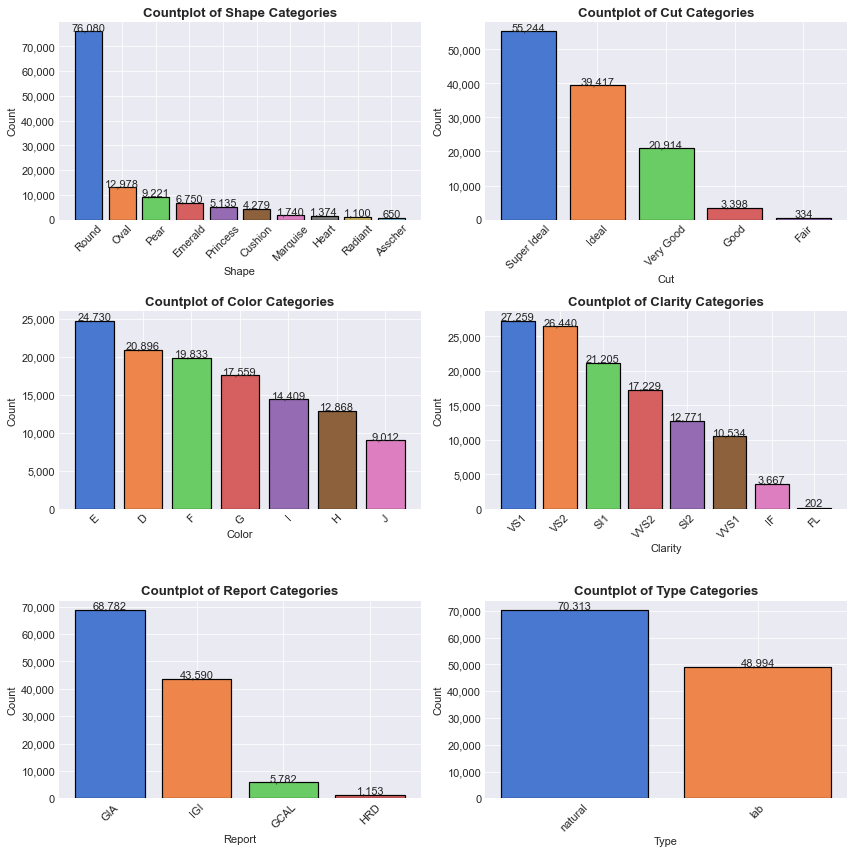

In [41]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

for n, col in enumerate(categorical_cols):
    ax = axes[n//2][n%2]
    countplot(column=col, fig=fig, ax=ax)
plt.tight_layout()

### Is there a relationship between a diamond's carat weight and its price? Do different categories affect price?

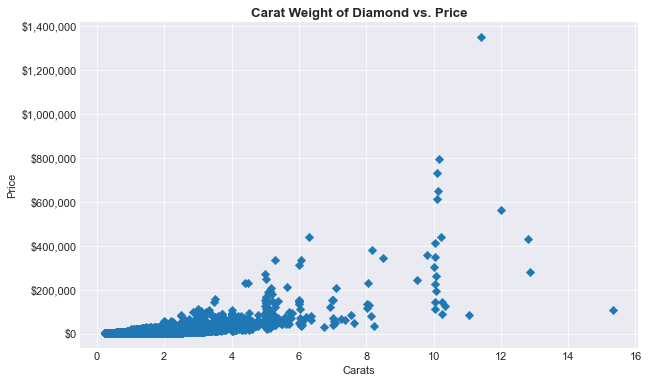

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=diamonds, x='carat', y='price', ax=ax, edgecolor=None, marker='D')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _:f'${y:,.0f}'))
ax.set_title('Carat Weight of Diamond vs. Price')
ax.set_xlabel('Carats')
ax.set_ylabel('Price');

There are several outliers that are skewing the price distribution of diamonds, rendering it hard to see the trend in the graph above. Let's try and isolate them, and see how many of them there are.

In [43]:
diamonds['std_price'] = (diamonds['price'] - diamonds['price'].mean()) / (diamonds['price'].std())

three_point_five_stds_above = diamonds.loc[diamonds['std_price'] > 3.5]
display(three_point_five_stds_above)

,shape,price,carat,cut,color,clarity,report,type,std_price
69991,Oval,35260,2.61,Super Ideal,F,VS2,GIA,natural,3.507869
69992,Emerald,35290,2.74,Good,D,VVS2,GIA,natural,3.511160
69993,Round,35360,3.00,Super Ideal,F,SI1,GIA,natural,3.518840
69994,Cushion,35450,3.00,Ideal,G,SI1,GIA,natural,3.528714
69995,Round,35540,2.90,Super Ideal,H,VS2,GIA,natural,3.538589
...,...,...,...,...,...,...,...,...,...
119302,Round,99040,5.71,Super Ideal,D,VVS2,GCAL,lab,10.505360
119303,Cushion,107330,15.32,Very Good,G,SI2,IGI,lab,11.414880
119304,Cushion,110110,10.05,Ideal,D,SI2,IGI,lab,11.719882
119305,Oval,126030,10.33,Fair,D,VS2,IGI,lab,13.466512


In [44]:
diamonds['sqrt_price'] = np.sqrt(diamonds['price'])

In [45]:
iqr = np.quantile(diamonds['price'], 0.75) - np.quantile(diamonds['price'], 0.25)
low_threshold = np.quantile(diamonds['price'], 0.25) - (1.5 * iqr)
high_threshold = np.quantile(diamonds['price'], 0.75) + (1.5 * iqr)

In [46]:
NO_OUTLIERS = (low_threshold < diamonds['price']) & (diamonds['price'] < high_threshold)
no_outliers = diamonds.loc[NO_OUTLIERS]
no_outliers.shape

(109120, 10)

The lowest priced outlier costs over $35,000. Let's temporarily remove these and look at the graphs of carat vs. price, with color encoding on the different categories shown in the previous bar graphs.

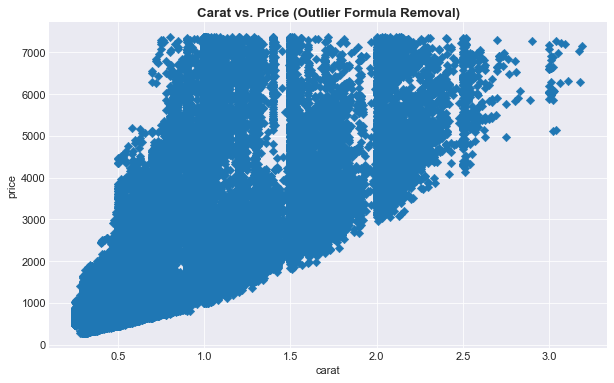

In [47]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=no_outliers, x='carat', y='price', edgecolor=None, marker='D')
plt.title('Carat vs. Price (Outlier Formula Removal)');

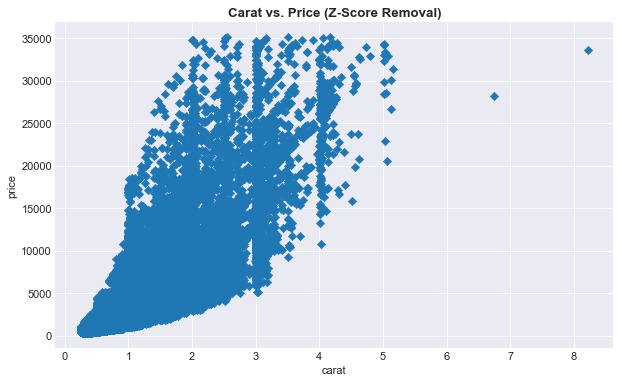

In [48]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=diamonds.drop(three_point_five_stds_above.index), x='carat', y='price', edgecolor=None, marker='D')
plt.title('Carat vs. Price (Z-Score Removal)');

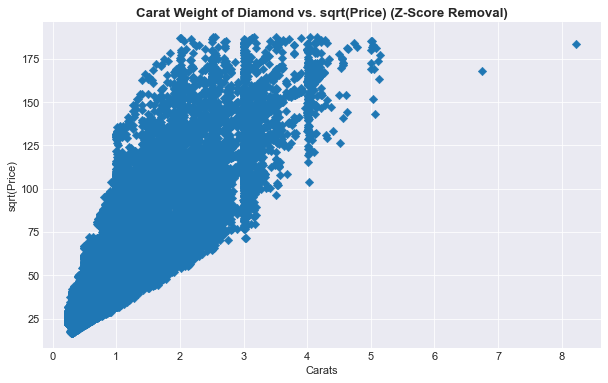

In [49]:
diamonds['sqrt_price'] = np.sqrt(diamonds['price'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=diamonds.drop(three_point_five_stds_above.index), x='carat', y='sqrt_price', ax=ax, edgecolor=None, marker='D')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _:f'{y:,.0f}'))
ax.set_title('Carat Weight of Diamond vs. sqrt(Price) (Z-Score Removal)')
ax.set_xlabel('Carats')
ax.set_ylabel('sqrt(Price)');

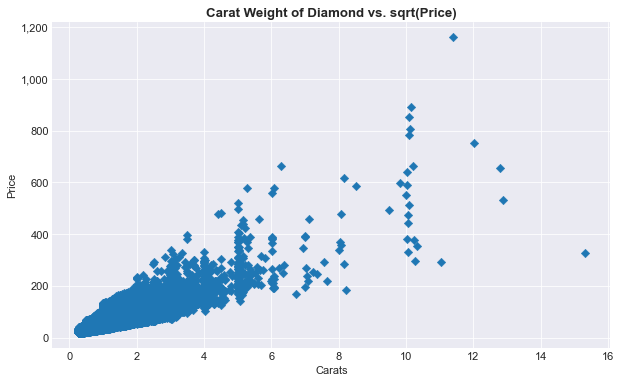

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=diamonds, x='carat', y='sqrt_price', ax=ax, edgecolor=None, marker='D')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _:f'{y:,.0f}'))
ax.set_title('Carat Weight of Diamond vs. sqrt(Price)')
ax.set_xlabel('Carats')
ax.set_ylabel('Price');

In [51]:
def carat_vs_price_by_column(df=diamonds, column=None, fig=None, ax=None, title='', ylabel=''):
    if (fig == None) & (ax == None):
        fig, ax = plt.subplots(figsize=(10, 6))

    sns.scatterplot(data=df, x='carat', y='price', edgecolor=None, hue=column, ax=ax, palette='muted', marker='D')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y * 1e-3:.0f}k'))
    ax.set_title(title)
    ax.set_xlabel('Carats')
    ax.set_ylabel(ylabel)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));

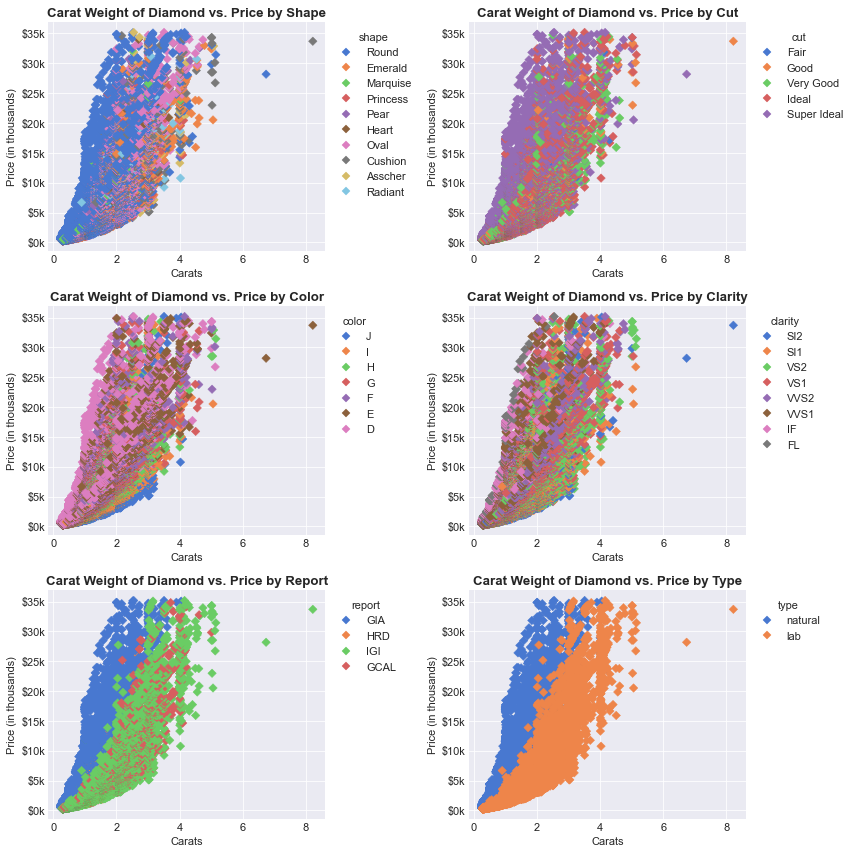

In [52]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
for n, col in enumerate(categorical_cols):
    ax = axes[n//2][n%2]
    carat_vs_price_by_column(df=diamonds.drop(three_point_five_stds_above.index),
                             column=col,
                             fig=fig,
                             ax=ax,
                             title=f'Carat Weight of Diamond vs. Price by {col.title()}',
                             ylabel=f'Price (in thousands)',
                             )
plt.tight_layout();

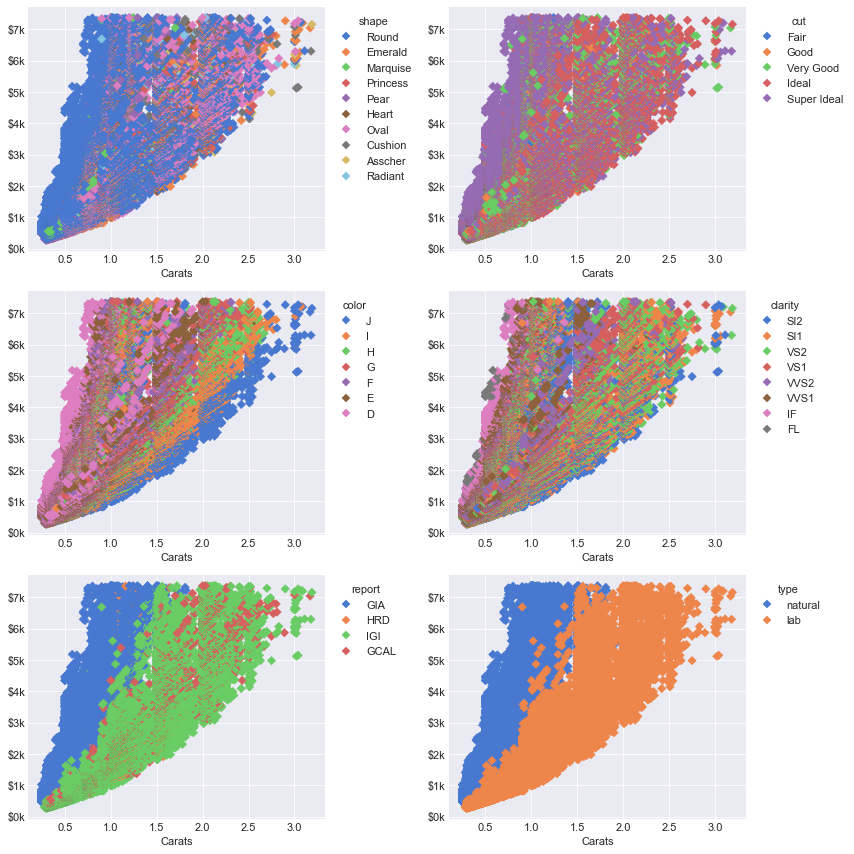

In [53]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
for n, col in enumerate(categorical_cols):
    ax = axes[n//2][n%2]
    carat_vs_price_by_column(df=no_outliers, column=col, fig=fig, ax=ax)
plt.tight_layout();

With outliers removed, it is easier to see that there is a clear positive correlation between carats and price. There are also indicators that round and oval shaped diamonds will tend to cost more than other shapes, GIA reports will tend to cost more, and natural diamonds will tend to cost more. Of course, the pricing also falls in line with the ordered categories of cut, clarity, and color, where super ideal cut diamonds will tend to cost more, "D" colored diamonds will tend to cost more, and flawless/internally flawless diamonds will tend to cost more. However, is this really the case?

### What are the price distributions of each category in each categorical column?

In [54]:
def boxplot_by_category(df=diamonds, x='sqrt_price', column=None, fig=None, ax=None, title='', xlabel='', ylabel=''):
    if (fig == None) & (ax == None):
        fig, ax = plt.subplots(figsize=(10, 6))

    sns.boxplot(data=df, x=x, ax=ax, hue=column, palette='muted', gap=0.2, fliersize=0.75)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x}'))
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));

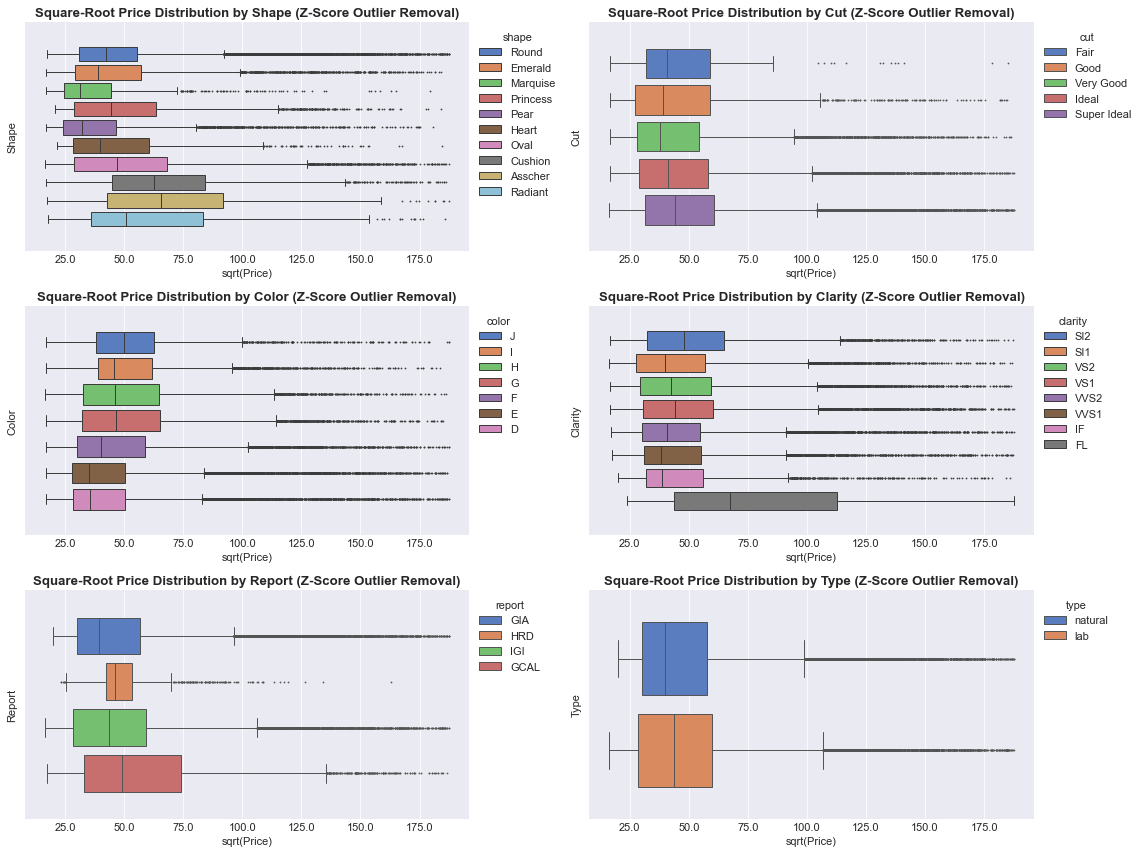

In [55]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
for n, col in enumerate(categorical_cols):
    ax = axes[n//2][n%2]
    boxplot_by_category(df=diamonds.drop(three_point_five_stds_above.index),
                        column=col,
                        fig=fig, ax=ax,
                        title=f'Square-Root Price Distribution by {col.title()} (Z-Score Outlier Removal)',
                        xlabel='sqrt(Price)',
                        ylabel=f'{col.title()}')
plt.tight_layout();

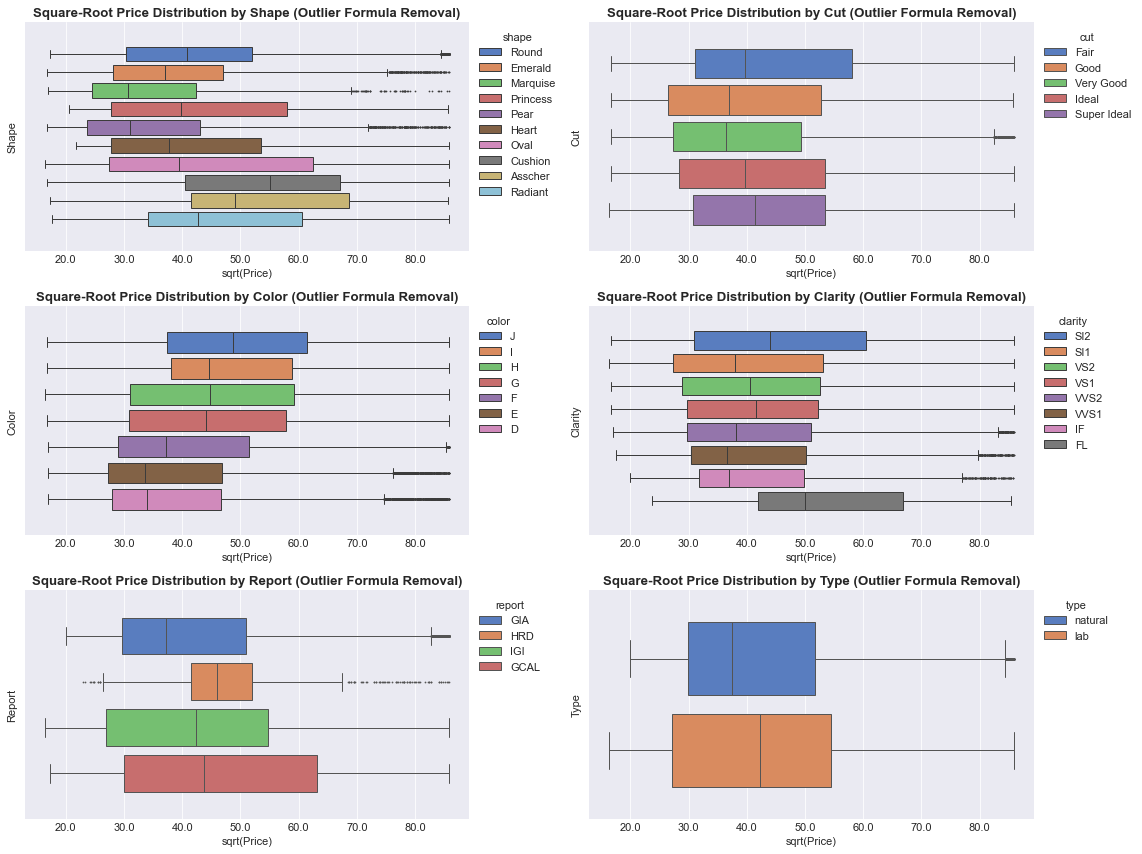

In [56]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
for n, col in enumerate(categorical_cols):
    ax = axes[n//2][n%2]
    boxplot_by_category(df=no_outliers,
                        column=col,
                        fig=fig, ax=ax,
                        title=f'Square-Root Price Distribution by {col.title()} (Outlier Formula Removal)',
                        xlabel='sqrt(Price)',
                        ylabel=f'{col.title()}')
plt.tight_layout();

# EDA: Inferential Analysis

In [64]:
def plot_distributions(df=diamonds, x='price', column=None, fig=None, ax=None, title='', xlabel=''):
    if (fig == None) & (ax == None):
        fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.kdeplot(data=df, x=x, hue=column, ax=ax, palette='muted')
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)

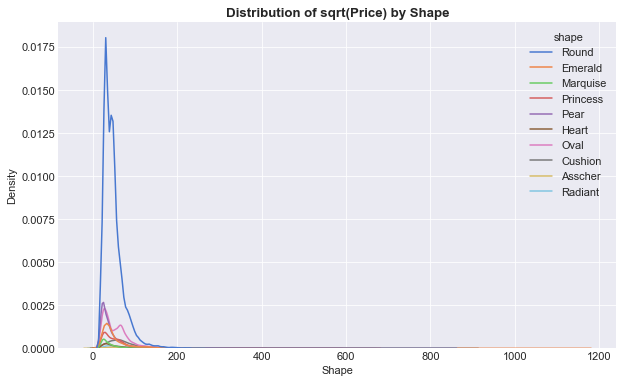

In [65]:
plot_distributions(column='shape', x='sqrt_price', title=f'Distribution of sqrt(Price) by Shape', xlabel='Shape')